Гипотеза 1: Влияние физической активности на качество сна

Существует ли статистически значимая зависимость между уровнем физической активности и качеством сна? Можно предположить, что люди с более высоким уровнем физической активности (измеряемой как минуты в день и количество ежедневных шагов) имеют более высокие показатели качества сна по шкале 1-10. Эта зависимость может быть нелинейной, так как избыточная физическая нагрузка также может негативно влиять на качество сна.

In [1]:
#Подготовка и проверка данных на полноту.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f_oneway
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')

# Устанавливаем стиль графиков
sns.set_style("whitegrid")

# Загружаем датасет
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

print('='*80)
print(f"Первые строки датасета:")
print(df.head(3))

# Удаляем строки с пропусками, если такие есть, в колонках 'Physical Activity Level', 'Daily Steps' и 'Quality of Sleep'
df_clean = df[['Physical Activity Level', 'Daily Steps', 'Quality of Sleep']].dropna()
print(f"После удаления пропусков: {df_clean.shape[0]} строк")
print('='*80)

Первые строки датасета:
   Person ID Gender  Age         Occupation  Sleep Duration  Quality of Sleep  \
0          1   Male   27  Software Engineer             6.1                 6   
1          2   Male   28             Doctor             6.2                 6   
2          3   Male   28             Doctor             6.2                 6   

   Physical Activity Level  Stress Level BMI Category Blood Pressure  \
0                       42             6   Overweight         126/83   
1                       60             8       Normal         125/80   
2                       60             8       Normal         125/80   

   Heart Rate  Daily Steps Sleep Disorder  
0          77         4200            NaN  
1          75        10000            NaN  
2          75        10000            NaN  
После удаления пропусков: 374 строк


Метод 1: Корреляция Спирмена (ранговая корреляция)

Краткое описание:
Ранговая корреляция Спирмена (ρ) — это непараметрический коэффициент, который измеряет степень монотонной зависимости между двумя переменными. Коэффициент принимает значения от -1 до +1, где положительные значения указывают на прямую связь, отрицательные — на обратную, а ноль означает отсутствие связи.

Почему используем?
1. Переменная "Quality of Sleep" имеет ранговую природу (шкала от 1 до 10), а не является истинно непрерывной величиной
2. Позволяет выявить как линейные, так и монотонные нелинейные связи

Значимость:
Тест проверяет нулевую гипотезу: коэффициент корреляции Спирмена (ρ) = 0, то есть отсутствует статистически значимая монотонная связь между физической активностью и качеством сна. Если p < 0.05, мы отклоняем нулевую гипотезу и заключаем, что связь статистически значима и не является результатом случайности.


Метод 1: Корреляция Спирмена (ранговая корреляция)

Корреляция Спирмена между 'Physical Activity Level' и 'Quality of Sleep':
Коэффициент корреляции: 0.1785
P-value: 0.000525
Связь статически значима на уровне 0.05
Положительная корреляция: больше активности - выше качество сна

Корреляция Спирмена между 'Daily Steps' и 'Quality of Sleep':
Коэффициент корреляции: 0.0228
P-value: 0.660581
Связь НЕ статистически значима (p > 0.05)


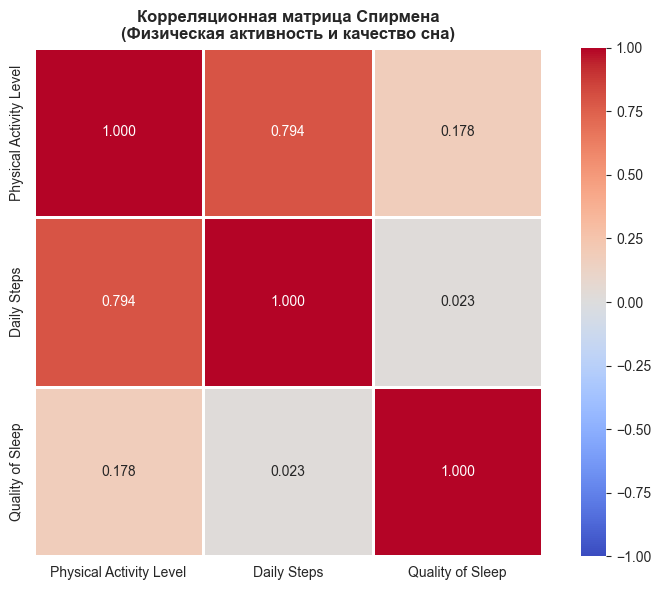

In [2]:
print(f"\n{'='*80}")
print("Метод 1: Корреляция Спирмена (ранговая корреляция)")


# Корреляция между Physical Activity Level и Quality of Sleep
corr_activity, p_value_activity = spearmanr(
    df_clean['Physical Activity Level'],
    df_clean['Quality of Sleep']
)

print(f"\nКорреляция Спирмена между 'Physical Activity Level' и 'Quality of Sleep':")
print(f"Коэффициент корреляции: {corr_activity:.4f}")
print(f"P-value: {p_value_activity:.6f}")

if p_value_activity < 0.05:
    print(f"Связь статически значима на уровне 0.05")
    if corr_activity > 0:
        print(f"Положительная корреляция: больше активности - выше качество сна")
    else:
        print(f"Отрицательная корреляция: больше активности - ниже качество сна")
else:
    print(f"Связь НЕ статистически значима (p > 0.05)")

# Корреляция между Daily Steps и Quality of Sleep
corr_steps, p_value_steps = spearmanr(
    df_clean['Daily Steps'],
    df_clean['Quality of Sleep']
)

print(f"\nКорреляция Спирмена между 'Daily Steps' и 'Quality of Sleep':")
print(f"Коэффициент корреляции: {corr_steps:.4f}")
print(f"P-value: {p_value_steps:.6f}")

# Тепловая карта для наглядности
if p_value_steps < 0.05:
    print(f"Связь СТАТИСТИЧЕСКИ ЗНАЧИМА на уровне 0.05")
    if corr_steps > 0:
        print(f" Положительная корреляция: больше шагов → выше качество сна")
    else:
        print(f"Отрицательная корреляция: больше шагов → ниже качество сна")
else:
    print(f"Связь НЕ статистически значима (p > 0.05)")

corr_matrix = df_clean.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=2, fmt='.3f',
            vmin=-1, vmax=1)
plt.title('Корреляционная матрица Спирмена\n(Физическая активность и качество сна)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("="*80)


Метод 2: Диаграмма рассеяния со LOWESS трендом (для выявления нелинейности)

Краткое описание:
LOWESS (Locally Weighted Scatterplot Smoothing) — это непараметрический метод визуализации зависимостей, который строит гладкую кривую тренда путём локального взвешивания точек данных. В каждой точке алгоритм вычисляет взвешенную регрессию, где ближайшие точки получают больший вес.

Почему используем?
1. Выявляет нелинейные закономерности, которые простая линейная регрессия может пропустить
2. Позволяет обнаружить возможный эффект плато — ситуацию, когда качество сна улучшается с активностью, но только до определённого предела, после чего эффект исчезает
3. Визуализирует тренд более надёжно, чем простая линия линейной регрессии

Значимость:
* Положительный наклон кривой - прямая связь (больше активности = лучше сон)
* Отрицательный наклон - обратная связь (больше активности = хуже сон)
* Волнистая/непрямая форма кривой - нелинейная зависимость, включая возможный эффект плато
* Плоская кривая - отсутствие связи

Метод 2: Диаграмма рассеяния со LOWESS трендом


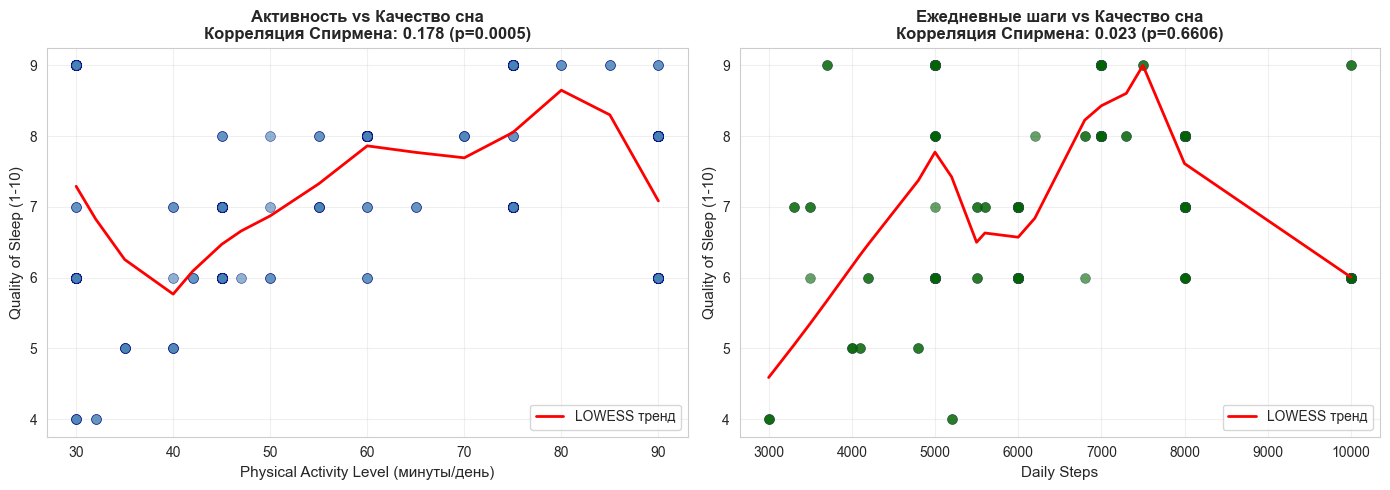

In [3]:
print("="*80)
print("Метод 2: Диаграмма рассеяния со LOWESS трендом")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Physical Activity Level vs Quality of Sleep
ax1 = axes[0]
ax1.scatter(df_clean['Physical Activity Level'], df_clean['Quality of Sleep'],
            alpha=0.6, s=50, color='steelblue', edgecolors='navy', linewidth=0.5)

lowess_result = lowess(df_clean['Quality of Sleep'],
                           df_clean['Physical Activity Level'],
                           frac=0.3)
ax1.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2, label='LOWESS тренд')


ax1.set_xlabel('Physical Activity Level (минуты/день)', fontsize=11)
ax1.set_ylabel('Quality of Sleep (1-10)', fontsize=11)
ax1.set_title(
    f'Активность vs Качество сна\nКорреляция Спирмена: {corr_activity:.3f} (p={p_value_activity:.4f})',
    fontsize=12, fontweight='bold'
)
ax1.grid(True, alpha=0.3)
ax1.legend()

# График 2: Daily Steps vs Quality of Sleep
ax2 = axes[1]
ax2.scatter(df_clean['Daily Steps'], df_clean['Quality of Sleep'],
            alpha=0.6, s=50, color='darkgreen', edgecolors='darkslategray', linewidth=0.5)

lowess_result2 = lowess(df_clean['Quality of Sleep'],
                            df_clean['Daily Steps'],
                            frac=0.3)
ax2.plot(lowess_result2[:, 0], lowess_result2[:, 1], 'r-', linewidth=2, label='LOWESS тренд')

ax2.set_xlabel('Daily Steps', fontsize=11)
ax2.set_ylabel('Quality of Sleep (1-10)', fontsize=11)
ax2.set_title(
    f'Ежедневные шаги vs Качество сна\nКорреляция Спирмена: {corr_steps:.3f} (p={p_value_steps:.4f})',
    fontsize=12, fontweight='bold'
)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
print("="*80)
